In [ ]:
import torch
import torch.nn as nn

import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Image Folder로 data load

In [ ]:
data_dir = '/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/bug/'

train_data_dir = '/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/bug/train'
test_data_dir = '/content/drive/Shareddrives/2022 데이터 청년 캠퍼스/bug/test'

Resize(normalization) the data

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(28),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(28),
        transforms.CenterCrop(28),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4, drop_last=True)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print("class_names : ", class_names)
print("\n")
print("datasets_sizes : ", dataset_sizes)
print("\n")
print("image_datasets : ", image_datasets)

class_names :  ['1.urticae', '10.intonsa', '11.despecta', '12.vaporariorum', '13.kanzawai', '15.antennata', '16.brassicae', '17.baccarum', '18.solani', '19.halys', '2.litura', '20.spiraecola', '21.segetum', '22.speculum', '23.latus', '24.striolata', '25.tabaci', '26.orana', '27.euphorbiae', '28.palmi', '29.agrestis', '3.exigua', '30.furnacalis', '31.cunea', '32. clavatus', '32.pruinosa', '34. assulta', '35. erysimi', '36.stali', '37.brassicae', '38. indica', '39.xylostella', '4.gossypii', '40.comstocki', '41.sordidus', '42.tabaci', '43.padi', '44.pentagona', '45.separata', '5.trifolii', '6.persicae', '7.lata', '8.armigera', '9.occidentalis']


datasets_sizes :  {'train': 433, 'test': 217}


image_datasets :  {'train': Dataset ImageFolder
    Number of datapoints: 433
    Root location: /content/drive/Shareddrives/2022 데이터 청년 캠퍼스/bug/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), inter

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


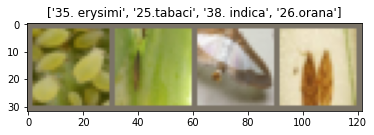

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Domain Adaptation Model


https://www.youtube.com/watch?v=U4ab267wl6U

In [ ]:
from torch.autograd import Function

In [ ]:
class GradientReversalFn(Function):
  @staticmethod
  def forward(ctx, x, alpha):
    #store context for backprop
    ctx.alpha=alpha
    return x

  @staticmethod
  def backward(ctx, grad_output):

    output= - ctx.alpha * grad_output

    return output, None


In [ ]:
w=torch.tensor([1,2,3,4.], requires_grad=True)
t=2*w+1
t=GradientReversalFn.apply(t, 0.5)
t

tensor([3., 5., 7., 9.], grad_fn=<GradientReversalFnBackward>)

In [ ]:
loss=torch.sum(t)
loss.backward(retain_graph=True)

w.grad

tensor([-1., -1., -1., -1.])

In [ ]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


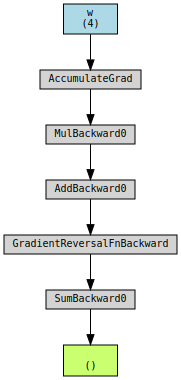

In [ ]:
import torchviz
from torchviz import make_dot  #pytorch 모델 시각화 방법

torchviz.make_dot(loss, params=dict(w=w))

In [ ]:
class DACNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.feature_extractor = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=5,padding=1,stride=1),    #(28+2p-f)/s+1=26
        nn.BatchNorm2d(64), nn.MaxPool2d(2), 
        nn.ReLU(True),  #26/2=13
        nn.Conv2d(64,50,kernel_size=5,padding=1,stride=1),   #(12+2p-f)/s+1=10
        nn.BatchNorm2d(50), nn.MaxPool2d(2), nn.ReLU(True),  #10/2=5
        nn.Dropout2d(),
    )
    self.num_cnn_features=50*5*5

    self.class_classifier = nn.Sequential(
        nn.Linear(self.num_cnn_features,100),nn.BatchNorm1d(100), nn.Dropout2d(), 
        nn.ReLU(True),
        nn.Linear(100,100),nn.BatchNorm1d(100), 
        nn.ReLU(True),
        nn.Linear(100,10),
        nn.LogSoftmax(dim=1),
    )

    self.domain_classifier=nn.Sequential(
        nn.Linear(self.num_cnn_features, 100), nn.BatchNorm1d(100),
        nn.ReLU(True),
        nn.Linear(100,2), 
        nn.LogSoftmax(dim=1),
    )
  
  def forward(self, x, grl_lamda=1.0):    
    #handle single channel input by expanding the singleton dimention
    x = x.expand(x.data.shape[0], 3, image_size, image_size)

    features = self.feature_extractor(x)
    features = features.view(-1, self.num_cnn_features)
    features_grl = GradientReversalFn.apply(features,grl_lamda)
    class_pred = self.class_classifier(features)                # classify on regular features
    domain_pred=self.domain_classifier(features_grl)            # classify on  features after GRL
    
    return class_pred, domain_pred

In [ ]:
model=DACNN()

x0_s,y0_s = next(iter(dataloaders['train']))
x0_t,y0_t = next(iter(dataloaders['test']))

print('source domain input: ', x0_s.shape, y0_s.shape)
print('target domain input: ', x0_t.shape, y0_t.shape)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


source domain input:  torch.Size([4, 3, 28, 28]) torch.Size([4])
target domain input:  torch.Size([4, 3, 28, 28]) torch.Size([4])


In [ ]:
# Test forward pass: get class prediction and domain prediction
image_size=28

yhat0_s_c, yhat0_s_d=model(x0_s)
yhat0_t_x, yhat0_t_d=model(x0_t)

print('yhat0_s_c: \n ', yhat0_s_c, yhat0_s_c.shape)
print('yhat0_t_d: \n ', yhat0_t_d, yhat0_t_d.shape)

yhat0_s_c: 
  tensor([[-1.6803, -2.4262, -2.5623, -2.0705, -2.6922, -2.4775, -2.9657, -2.4124,
         -2.2551, -2.0844],
        [-3.5992, -2.4334, -2.4860, -2.3646, -1.5668, -2.7775, -2.3186, -2.7383,
         -1.6601, -2.4820],
        [-2.4120, -2.0034, -2.4964, -2.1791, -2.6809, -2.3067, -1.7196, -2.7941,
         -2.6609, -2.2859],
        [-2.7566, -2.6862, -1.9852, -2.2267, -2.2869, -1.4500, -2.8431, -2.7967,
         -3.0400, -2.1214]], grad_fn=<LogSoftmaxBackward0>) torch.Size([4, 10])
yhat0_t_d: 
  tensor([[-0.6790, -0.7075],
        [-0.5428, -0.8701],
        [-0.5625, -0.8435],
        [-0.7523, -0.6373]], grad_fn=<LogSoftmaxBackward0>) torch.Size([4, 2])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [ ]:
model(x0_s)
model(x0_t)

#model_ft = train_model(model, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


(tensor([[-2.9116, -3.1509, -2.6150, -1.9282, -2.1220, -1.3509, -2.7064, -2.9286,
          -2.2416, -2.5397],
         [-2.2451, -2.0661, -2.0235, -2.3555, -2.0795, -2.8976, -2.3684, -2.4557,
          -2.7788, -2.1315],
         [-2.2615, -2.1384, -2.2494, -2.0849, -2.8052, -2.4376, -2.6903, -2.8941,
          -2.2312, -1.7737],
         [-2.8318, -2.1862, -2.4193, -2.2644, -2.1315, -2.2389, -1.9939, -2.2660,
          -2.3489, -2.5864]], grad_fn=<LogSoftmaxBackward0>),
 tensor([[-0.5686, -0.8355],
         [-0.8163, -0.5835],
         [-0.4365, -1.0392],
         [-0.7664, -0.6249]], grad_fn=<LogSoftmaxBackward0>))

# Training

In [ ]:
lr = 1e-3
n_epochs=1

In [ ]:
#setup

model=DACNN()
optimizer=optim.Adam(model.parameters(), lr)

In [ ]:
# two loss functions 
loss_fn_class=torch.nn.NLLLoss()
loss_fn_domain=torch.nn.NLLLoss()

In [ ]:
batch_size=256

In [ ]:
max_batches = min(len(dataloaders['train']), len(dataloaders['test']))
max_batches

54

In [ ]:
for epoch_idx in range(n_epochs):
  #print(f'Epoch {epoch_idx+1:04d}/{n_epochs:04d}', end='\n========================\n')
  print(f'Epoch {epoch_idx}/{n_epochs - 1}', end='\n========================\n')

  dl_source_iter=iter(dataloaders['train'])
  dl_target_iter=iter(dataloaders['test'])

  for batch_idx in range(max_batches):
    optimizer.zero_grad()

    p=float(batch_idx + epoch_idx* max_batches)/(n_epochs * max_batches)
    grl_lambda=2./(1.+np.exp(-10*p))-1

    # Train: source  domain
    x_s,y_s=next(dl_source_iter)
    y_s_domain=torch.zeros(batch_size, dtype=torch.long)

    class_pred, domain_pred=model(x_s, grl_lambda)
    loss_s_label=loss_fn_class(class_pred, y_s)
    loss_s_domain=loss_fn_class(domain_pred, y_s_domain)

    # Train: target domain
    x_t, _ =next(dl_target_iter)
    y_t_domain=torch.ones(batch_size, dtype=torch.long)

    _, domain_pred=model(x_t, grl_lambda)
    loss_t_domain=loss_fn_domain(domain_pred, y_t_domain)

    #최적화
    loss=loss_t_domain+loss_s_domain+loss_s_label
    loss.backward()
    optimizer.step()

    print(f'[{batch_idx+1}/{max_batches}]'
          f'class loss: {loss_s_label.item(): .4f}'
          f's_domain_loss: {loss_s_domain.item(): .4f}'
          f't_domain loss: {loss_s_domain.item(): .4f}',
          f'grl_lambda: {grl_lambda: .3f}'
          )


Epoch 0/0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


IndexError: ignored

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    dl_source_iter=iter(dataloaders['train'])
    dl_target_iter=iter(dataloaders['test'])

    for epoch_idx in range(n_epochs):
        print(f'Epoch {epoch_idx}/{n_epochs - 1}')
        print('=' * 10)

        # Each epoch has a training and validation phase
        #for phase in ['train', 'test']:
        #    if phase == 'train':
        #       model.train()  # Set model to training mode
        #   else:
        #       model.eval()   # Set model to evaluate mode

        #   running_loss = 0.0
        #   running_corrects = 0

            # Iterate over data.
        for batch_idx in range(max_batches):
            #for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                #labels = labels.to(device)

                # zero the parameter gradients
          optimizer.zero_grad()

          p=float(batch_idx + epoch_idx* max_batches)/(n_epochs * max_batches)
          grl_lambda=2./(1.+np.exp(-10*p))-1
                
                # forward
                # track history if only in train
                # Train: source  domain
          x_s,y_s=next(dl_source_iter)
          y_s_domain=torch.zeros(batch_size, dtype=torch.long)

          class_pred, domain_pred=model(x_s, grl_lambda)
          loss_s_label=loss_fn_class(class_pred, y_s)
          loss_s_domain=loss_fn_class(domain_pred, y_s_domain)

                # Train: target domain
          x_t, _ =next(dl_target_iter)
          y_t_domain=torch.ones(batch_size, dtype=torch.long)

          _, domain_pred=model(x_t, grl_lambda)
          loss_t_domain=loss_fn_domain(domain_pred, y_t_domain)

                #backward + optimize only if in training phase
          loss = loss_t_domain+loss_s_domain+loss_s_label
          loss.backward()
          optimizer.step()
                
                
          print(f'[{batch_idx+1}/{max_batches}]'
                f'class loss: {loss_s_label.item(): .4f}'
                f's_domain_loss: {loss_s_domain.item(): .4f}'
                f't_domain loss: {loss_s_domain.item(): .4f}',
                f'grl_lambda: {grl_lambda: .3f}'
          )

                #if batch_idx==10:
                 # print('stop')
                 # break

In [ ]:
#finetuning

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).

# resnet18 모델을 가져와 기존의 feature를, nn.Linear를 사용하여 n개의 featrue를 분류
model_ft.fc = nn.Linear(num_ftrs, 45)

model_ft = model_ft.to(device)

# 손실함수 정의
criterion = nn.CrossEntropyLoss()

# Optimzer 정의
# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model.parameters(), lr)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
